<a href="https://colab.research.google.com/github/Riponcs/Deep_Learning/blob/master/Neural_style_transfer_in_KerasV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.preprocessing.image import load_img, img_to_array
target_image_path = '/content/drive/My Drive/AdvancedDeepLearning/korea.jpeg'
style_reference_image_path = '/content/drive/My Drive/AdvancedDeepLearning/style.jpg'
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Using TensorFlow backend.


In [0]:
import numpy as np
from keras.applications import vgg19
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_image(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [5]:
from keras import backend as K
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([target_image,
style_reference_image,
combination_image], axis=0)
model = vgg19.VGG19(input_tensor=input_tensor,
weights='imagenet',
include_top=False)
print('Model loaded.')











Model loaded.


In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

In [0]:
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

In [0]:
def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
  a = K.square(x[:, :img_height - 1, :img_width - 1, :] -x[:, 1:, :img_width - 1, :])
  b = K.square(x[:, :img_height - 1, :img_width - 1, :] -x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

In [11]:
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

In [0]:
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [13]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])
class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
evaluator = Evaluator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Need to Install scipy V 1.2.0 [uninstal scipy-1.3.2 autometically]
# !pip install -U scipy==1.3.2

In [16]:
from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave
import imageio # Add in addition
import time

result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
  print('Current loss value:', min_val)
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  imageio.imwrite(fname, img) #imsave(fname, img)
  print('Image saved as', fname)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 5881991700.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 430s
Start of iteration 1
Current loss value: 2804597800.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 428s
Start of iteration 2
Current loss value: 2083039100.0
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 428s
Start of iteration 3
Current loss value: 1749662500.0
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 428s
Start of iteration 4
Current loss value: 1541341200.0
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 430s
Start of iteration 5
Current loss value: 1399904800.0
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 428s
Start of iteration 6
Current loss value: 1299631400.0
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 427s
Start of iteration 7
Current loss value: 1215574300.0
Image saved as my_result_at_iteration_7.png
Iterat

In [0]:
imageio.imsave('/content/drive/My Drive/AdvancedDeepLearning/koreaStyle.jpeg', img)

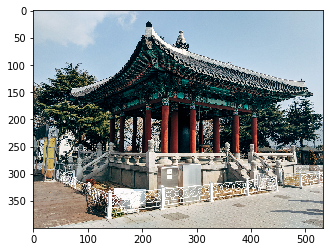

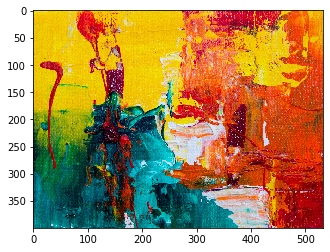

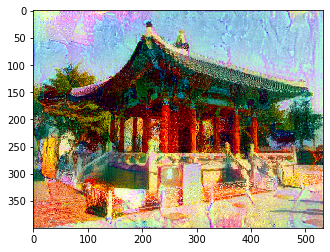

In [20]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()